# OpenAP - Estimation Fuel and Emissions

## Install OpenAP


In [ ]:
%pip install OpenAP

Import packages

In [1]:
import openap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv("data/flight_a320_orig.csv")

df = df[
    [
        "FLIGHT_TIME",
        "ALTI_STD_FT",
        "GRND_SPD_KT",
        "TRUE_AIR_SPD_KT",
        "VERT_SPD_FTMN",
        "MASS_KG",
        "FUEL_FLOW_KGH",
    ]
]

df.columns = [
    "time",
    "altitude",
    "groundspeed",
    "true_airspeed",
    "vertical_rate",
    "mass",
    "fuel_flow",
]


df.query("altitude>60").eval("fuel_flow=fuel_flow / 3600 * 2").to_csv(
    "data/flight_a320.csv", index=False
)

In [2]:
flight = pd.read_csv('data/flight_a320.csv')

In [5]:
flight.head()

,time,altitude,groundspeed,true_airspeed,vertical_rate,mass,fuel_flow
0,527.0,60.453125,31.777344,31.777344,0.0,69762.525139,2.131332
1,528.0,64.000000,36.777344,36.777344,0.0,69762.525139,2.105302
2,529.0,64.453125,41.777344,41.777344,0.0,69762.525139,2.078511
3,530.0,68.000000,46.777344,46.777344,0.0,69762.525139,2.079815
4,531.0,68.453125,51.421875,51.421875,0.0,69762.525139,2.062612


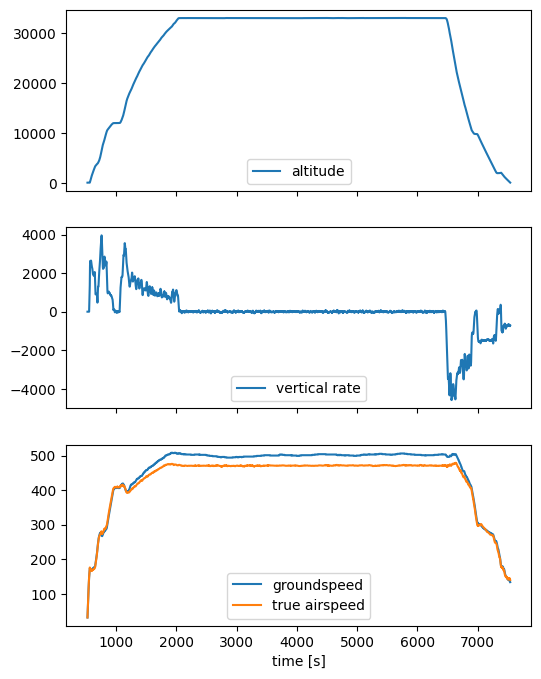

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8), sharex=True) 

ax1.plot(flight.time, flight.altitude, label="altitude")
ax2.plot(flight.time, flight.vertical_rate, label="vertical rate")
ax3.plot(flight.time, flight.groundspeed, label="groundspeed")
ax3.plot(flight.time, flight.true_airspeed, label="true airspeed")
for ax in (ax1, ax2, ax3):
    ax.legend(loc="lower center")
ax3.set_xlabel("time [s]")
plt.show()

In [5]:
ff = openap.FuelFlow(ac="a320")

fuel_flow_estimate = ff.enroute(
    flight.mass, flight.true_airspeed, flight.altitude, flight.vertical_rate
)


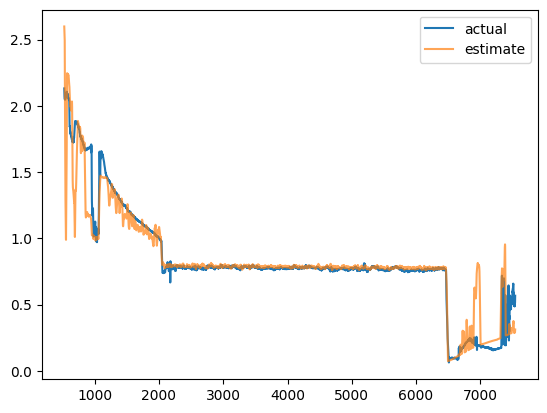

In [6]:
plt.plot(flight.time, flight.fuel_flow, label="actual")
plt.plot(flight.time, fuel_flow_estimate, label="estimate", alpha=0.7)
plt.legend()
plt.show()

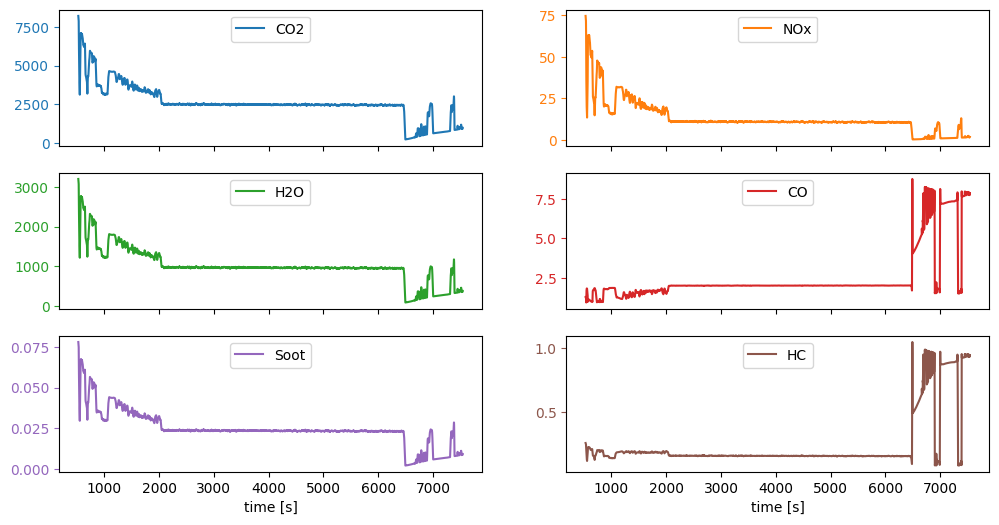

In [7]:
emi = openap.Emission(ac="a320")

co2 = emi.co2(fuel_flow_estimate)
h2o = emi.h2o(fuel_flow_estimate)
soot = emi.soot(fuel_flow_estimate)

nox = emi.nox(fuel_flow_estimate, flight.true_airspeed, flight.altitude)
co = emi.co(fuel_flow_estimate, flight.true_airspeed, flight.altitude)
hc = emi.hc(fuel_flow_estimate, flight.true_airspeed, flight.altitude)

fig, axes = plt.subplots(3, 2, figsize=(12, 6), sharex=True)

colors = plt.cm.tab10.colors
gases = [co2, nox, h2o, co, soot, hc]
labels = ["CO2", "NOx", "H2O", "CO", "Soot", "HC"]
for i, (gas, ax) in enumerate(zip(gases, axes.flat)):
    ax.plot(flight.time, gas, color=colors[i], label=labels[i])
    ax.legend(loc="upper center")
    ax.tick_params(axis='y', colors=colors[i])
for ax in axes[-1, :]:
    ax.set_xlabel("time [s]")
